# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

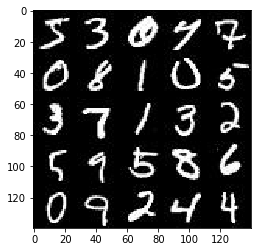

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

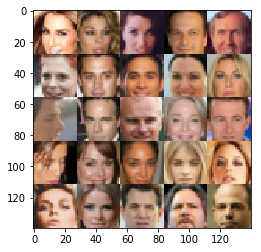

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [30]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function  
    input_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), 'Real_Input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), 'Z_Input')
    lr = tf.placeholder(tf.float32,name='learning_rate')
    return input_real,input_z,lr 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [71]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*x1,x1)
        relu1 = tf.nn.dropout(relu1,0.8)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print(x2)
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        relu2 = tf.nn.dropout(relu2,0.8)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print(x3)
        bn3 = tf.layers.batch_normalization(x2,training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        relu3 = tf.nn.dropout(relu3,0.8)
        
        #Flatten it
        flatten = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flatten,1)
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [72]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator',reuse= not is_train):
        x1 = tf.layers.dense(z,7*7*512)
        
        x1 = tf.reshape(x1,(-1,7,7,512))
        bn1 = tf.layers.batch_normalization(x1,training=is_train)
        relu1 = tf.maximum(alpha*bn1,bn1)
        relu1 = tf.nn.dropout(relu1,0.5)
        
        x2 = tf.layers.conv2d_transpose(relu1,256,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=is_train)
        relu2 = tf.maximum(alpha*bn2,bn2)
        relu2 = tf.nn.dropout(relu2,0.5)
        
        x3 = tf.layers.conv2d_transpose(relu2,128,5,strides=2,padding='same')
        #print(x3)
        bn3 = tf.layers.batch_normalization(x3,training=is_train)
        relu3 = tf.maximum(alpha*bn3,bn3)
        relu3 = tf.nn.dropout(relu3,0.5)
        #print(relu3)
       # x4 = tf.layers.conv2d_transpose(relu3,64,5,strides=2,padding='same')
       # bn4 = tf.layers.batch_normalization(x4,training=is_train)
       # relu4 = tf.maximum(alpha*bn4,bn4)
        
        #Output Layer
        logits = tf.layers.conv2d_transpose(relu3,out_channel_dim,5,strides=1,padding='same')
        #print(logits)
        output = tf.nn.tanh(logits)
        #print(output)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [61]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real*(1-0.1))))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    #print(d_loss)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    #print(g_loss)
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [75]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [84]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples,losses = [],[]
    steps = 0
    n_examples,w,h,d = data_shape
    real_inputs,z_inputs,learning_rate_input = model_inputs(w,h,d,z_dim)
    d_loss,g_loss = model_loss(real_inputs,z_inputs,d)
    d_train_opt,g_train_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                #Change the range from (-0.5,0.5) to (-1,1) 
                batch_images *= 2
                #print("Min/Max: {} / {}".format(np.min(batch_images),np.max(batch_images)))
                batch_z = np.random.uniform(-1,1,(batch_size,z_dim))
                
                _ = sess.run(d_train_opt,feed_dict=
                            {real_inputs:batch_images,z_inputs:batch_z,learning_rate_input:learning_rate})
                _ = sess.run(g_train_opt,feed_dict=
                            {real_inputs:batch_images,z_inputs:batch_z,learning_rate_input:learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({real_inputs:batch_images,z_inputs:batch_z})
                    train_loss_g = g_loss.eval({z_inputs:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess,25,z_inputs,d,data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 1.4746
Epoch 1/2... Discriminator Loss: 0.3565... Generator Loss: 1.9914
Epoch 1/2... Discriminator Loss: 0.1708... Generator Loss: 2.8072
Epoch 1/2... Discriminator Loss: 0.0512... Generator Loss: 3.9937
Epoch 1/2... Discriminator Loss: 0.0673... Generator Loss: 4.2026
Epoch 1/2... Discriminator Loss: 0.0297... Generator Loss: 4.7041
Epoch 1/2... Discriminator Loss: 0.0228... Generator Loss: 4.5948
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 5.6153


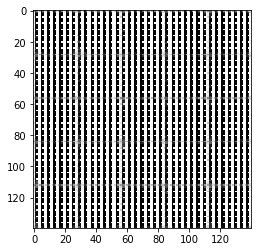

Epoch 1/2... Discriminator Loss: 0.0088... Generator Loss: 5.7502
Epoch 1/2... Discriminator Loss: 0.0195... Generator Loss: 4.3894
Epoch 1/2... Discriminator Loss: 0.0579... Generator Loss: 4.6210
Epoch 1/2... Discriminator Loss: 0.0111... Generator Loss: 5.9036
Epoch 1/2... Discriminator Loss: 0.0237... Generator Loss: 4.6340
Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 5.5158
Epoch 1/2... Discriminator Loss: 0.0066... Generator Loss: 6.6306
Epoch 1/2... Discriminator Loss: 0.0057... Generator Loss: 6.7493
Epoch 1/2... Discriminator Loss: 0.0040... Generator Loss: 7.0366
Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 7.1909


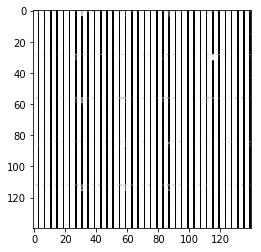

Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 7.3380
Epoch 1/2... Discriminator Loss: 0.0047... Generator Loss: 6.0820
Epoch 1/2... Discriminator Loss: 0.7885... Generator Loss: 1.1793
Epoch 1/2... Discriminator Loss: 0.0993... Generator Loss: 3.6025
Epoch 1/2... Discriminator Loss: 0.0342... Generator Loss: 4.3559
Epoch 1/2... Discriminator Loss: 0.0219... Generator Loss: 4.9238
Epoch 1/2... Discriminator Loss: 0.0487... Generator Loss: 4.3847
Epoch 1/2... Discriminator Loss: 0.0775... Generator Loss: 3.9491
Epoch 1/2... Discriminator Loss: 0.5741... Generator Loss: 1.7092
Epoch 1/2... Discriminator Loss: 0.3236... Generator Loss: 2.4005


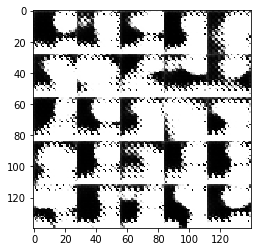

Epoch 1/2... Discriminator Loss: 0.1037... Generator Loss: 3.5260
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 2.4919
Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 1.7466
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 1.2286
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 1.4413
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.8898


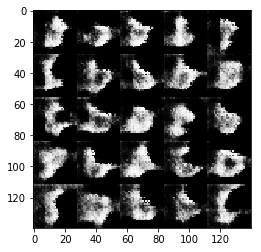

Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.6727
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 1.0759


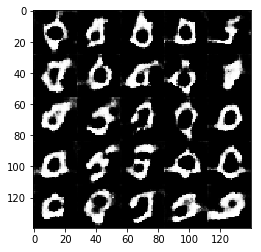

Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 1.0236


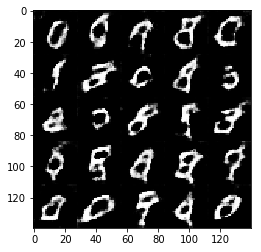

Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 0.9249
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.9438


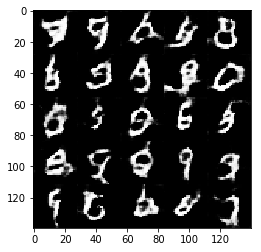

Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.8353
Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.8630
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.8055


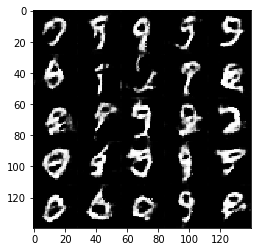

Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.7736
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.9340


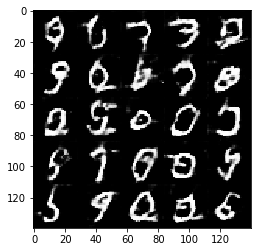

Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.9597
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.9282
Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.8349
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.9602


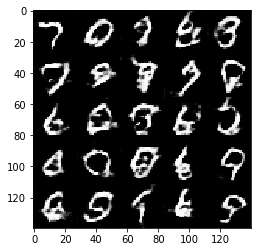

Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.8203
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 0.8228


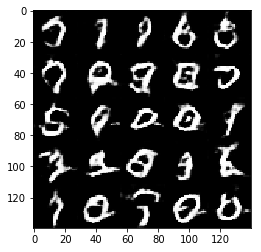

Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.9291
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 1.0016


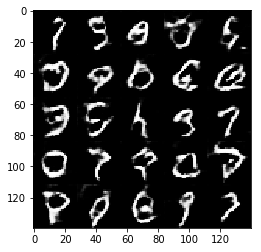

Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 1.2354
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.8536
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 1.0116


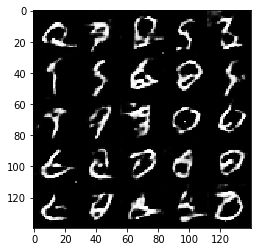

Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.8007


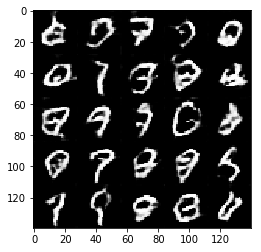

Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 1.3578... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.9175
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.7554


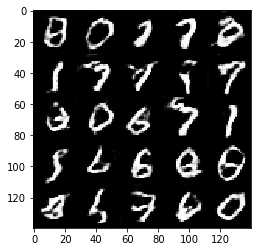

Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.8691
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.8984
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 1.0367


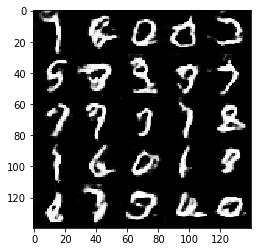

Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 1.3346... Generator Loss: 0.9782
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.8122


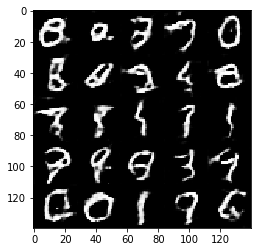

Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.7860
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.8708


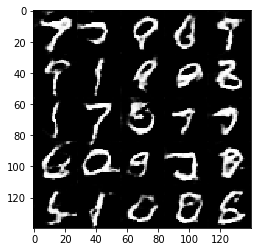

Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.6287
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.9734


In [85]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.9326


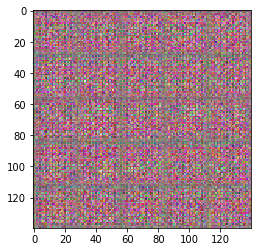

Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3492
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 1.8519
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 2.1421
Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 2.2665
Epoch 1/1... Discriminator Loss: 0.3123... Generator Loss: 2.2308
Epoch 1/1... Discriminator Loss: 0.2413... Generator Loss: 2.5571


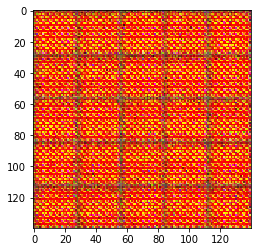

Epoch 1/1... Discriminator Loss: 0.2647... Generator Loss: 2.3871
Epoch 1/1... Discriminator Loss: 0.2113... Generator Loss: 2.5846
Epoch 1/1... Discriminator Loss: 0.1982... Generator Loss: 2.8104
Epoch 1/1... Discriminator Loss: 0.1701... Generator Loss: 2.9297
Epoch 1/1... Discriminator Loss: 0.1766... Generator Loss: 2.9995
Epoch 1/1... Discriminator Loss: 0.1471... Generator Loss: 3.0419
Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 2.2824
Epoch 1/1... Discriminator Loss: 0.1816... Generator Loss: 2.9369
Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 3.0897
Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 3.1191


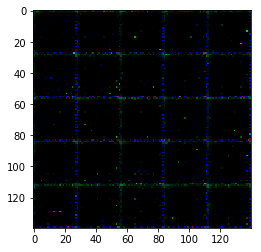

Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 3.0759
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 3.1011
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.9954
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 2.7985
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 2.9703
Epoch 1/1... Discriminator Loss: 0.2070... Generator Loss: 2.5103
Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 2.6129
Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 3.1162
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 2.6204
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 2.9482


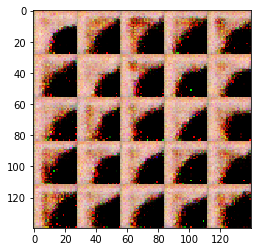

Epoch 1/1... Discriminator Loss: 0.2252... Generator Loss: 3.2713
Epoch 1/1... Discriminator Loss: 0.2228... Generator Loss: 2.4547
Epoch 1/1... Discriminator Loss: 0.2101... Generator Loss: 2.4575
Epoch 1/1... Discriminator Loss: 0.2108... Generator Loss: 3.3729
Epoch 1/1... Discriminator Loss: 0.2457... Generator Loss: 2.4761
Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 2.6882
Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 2.6366
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 2.1985
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 1.5103
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 3.2303


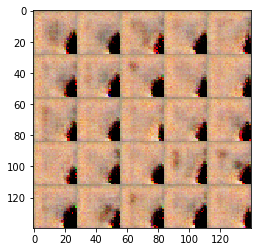

Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 2.3426
Epoch 1/1... Discriminator Loss: 0.3041... Generator Loss: 2.3568
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 1.6425
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 1.5126
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.6676
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.5055


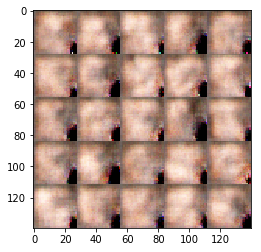

Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.1810


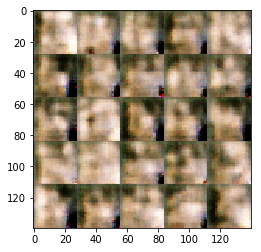

Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.6995
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.1440


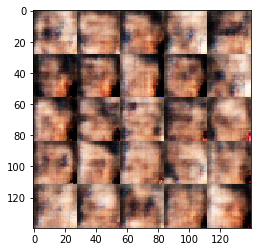

Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.0102


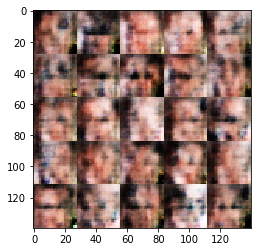

Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.9222


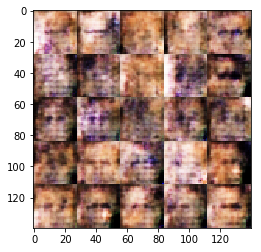

Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.9918


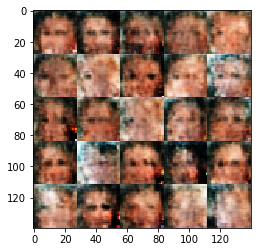

Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.7480


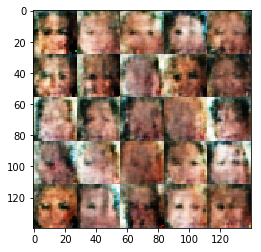

Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8700


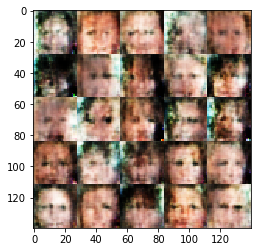

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.8507


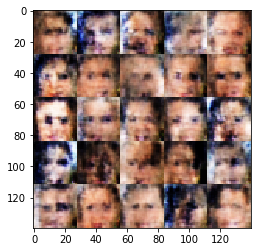

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.8482


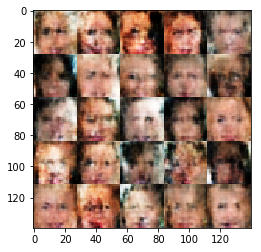

Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8832


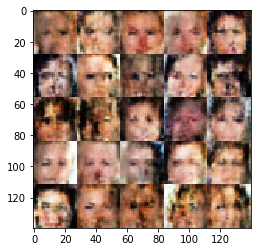

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8877


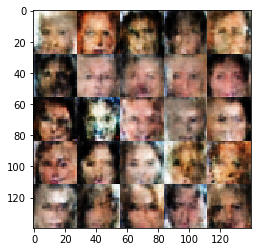

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8137


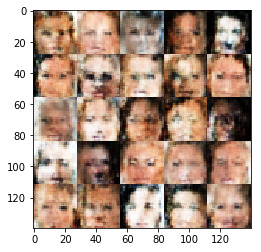

Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9943


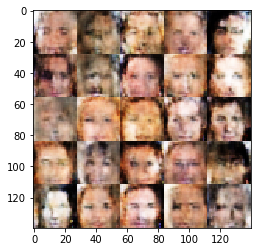

Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.9164


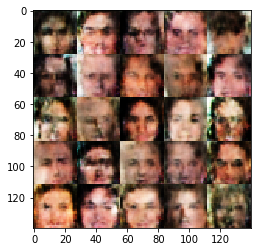

Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8909


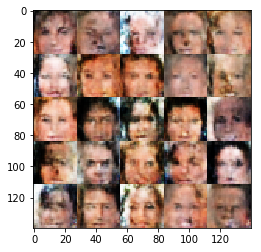

Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.8182


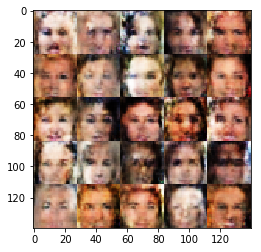

Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.9034


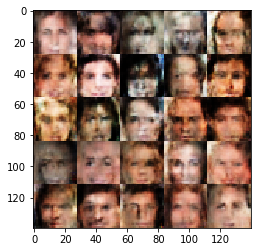

Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 3.3769... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 1.6673


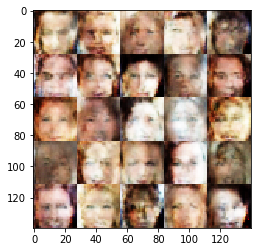

Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7856


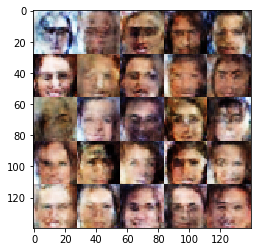

Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8445


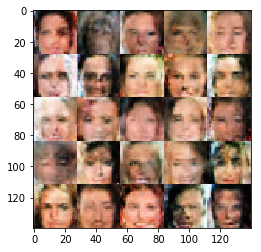

Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.0894


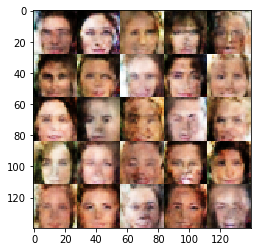

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7716


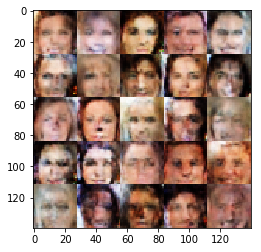

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9112


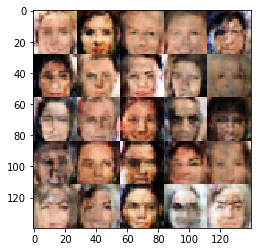

Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8809


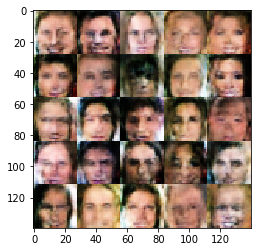

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.9136


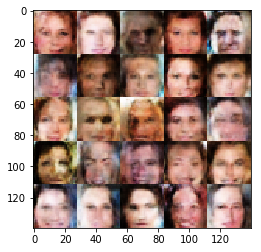

Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8791


In [86]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。